# Variatinal Auto Encoder

Autor: Morariu Tudor

## Citirea Datelor

In [ ]:
import keras
import numpy as np

(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)


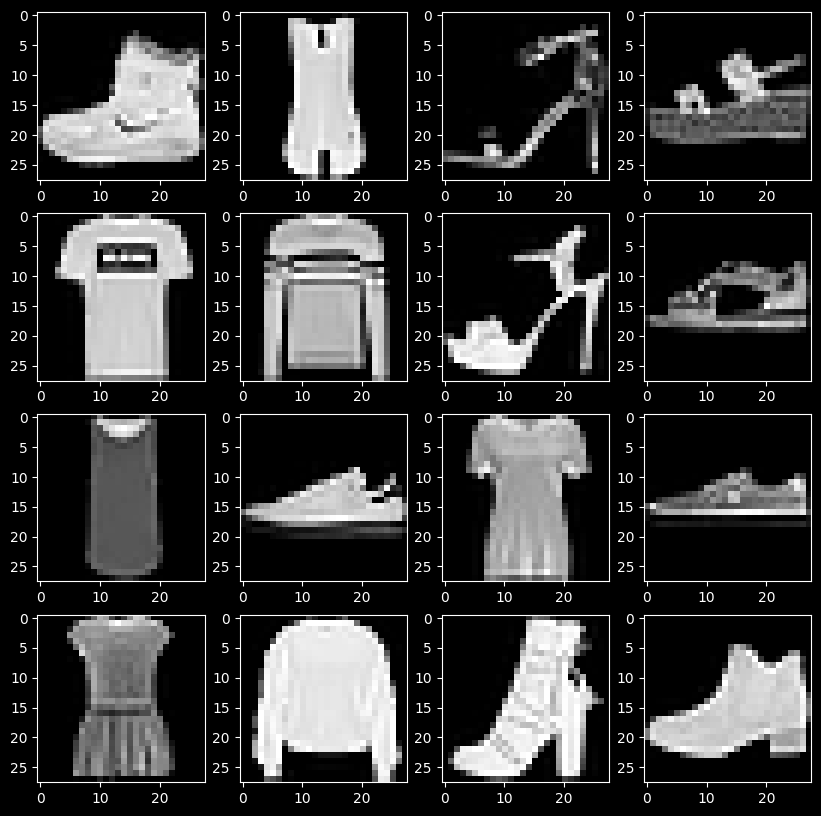

In [ ]:
import matplotlib.pyplot as plt

plt.style.use("dark_background")

f, ax = plt.subplots(4, 4);

f.set_figheight(10);
f.set_figwidth(10);


for i in range(16):
  img = x_train[i];

  ax[i % 4][i // 4].imshow(img, cmap="gray");

## Definirea VAE

In [ ]:
import torch.nn as nn

class TheMegaAutoEncoder(nn.Module):

  def __init__(self):

    # Chem constructor-ul parinte
    super().__init__()

    # Dimensiunea pentru latent layer este 8
    self.num_hidden = 8

    self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, self.num_hidden),
            nn.ReLU(),
        )

    self.decoder = nn.Sequential(
            nn.Linear(self.num_hidden, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 2056),
            nn.ReLU(),
            nn.Linear(2056, 3136),
            nn.Sigmoid(),
        )

  def forward(self, features):

    encoded = self.encoder(features)
    decoded = self.decoder(encoded)

    return encoded, decoded

  def test_image(self, image):

    encoded = self.encoder(image)
    decoded = self.decoder(encoded)

    trippy_image = decoded.reshape(56, 56);

    return trippy_image



### Hiperparametrii

In [ ]:
import torch


x_tensor = torch.from_numpy(x_train)

model = TheMegaAutoEncoder()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()


device = torch.device("cuda")

model.to(device);
x_tensor.to(device);


### Data split

In [ ]:
train_loader = torch.utils.data.DataLoader(
    x_tensor, batch_size=64, shuffle=True
)

### Model Train

In [ ]:
import PIL.Image

for epoch in range(10):
    total_loss = 0.0
    for batch_idx, data in enumerate(train_loader):
        data_resize = data
        new_data = np.array([])


        for elm in data_resize:
          img = PIL.Image.fromarray(np.float32(elm))
          img_r = img.resize((56, 56));
          #display(img);
          #display(img_r);


          new_data = np.append(new_data, np.array(img_r));

        data = torch.tensor(data.reshape(-1, 784), dtype=torch.float32);
        data = data.to(device)

        data_loss = torch.tensor(new_data.reshape(-1, 3136), dtype=torch.float32);
        data_loss = data_loss.to(device)


        encoded, decoded = model(data)
        #print("enc: ", encoded.shape)
        #print("dec: ", decoded.shape)


        loss = loss_fn(decoded, data_loss)
        opt.zero_grad()
        loss.backward()
        opt.step()

        total_loss += loss.item() * data.size(0)

    epoch_loss = total_loss / len(train_loader.dataset)
    print("Epoch {}/{}: loss={:.4f}".format(epoch + 1, 10, epoch_loss))



<ipython-input-17-383900bc3a7c>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data.reshape(-1, 784), dtype=torch.float32);


Epoch 1/10: loss=0.0321
Epoch 2/10: loss=0.0207
Epoch 3/10: loss=0.0193
Epoch 4/10: loss=0.0187
Epoch 5/10: loss=0.0183
Epoch 6/10: loss=0.0180
Epoch 7/10: loss=0.0178
Epoch 8/10: loss=0.0176
Epoch 9/10: loss=0.0174
Epoch 10/10: loss=0.0173


## Prediction

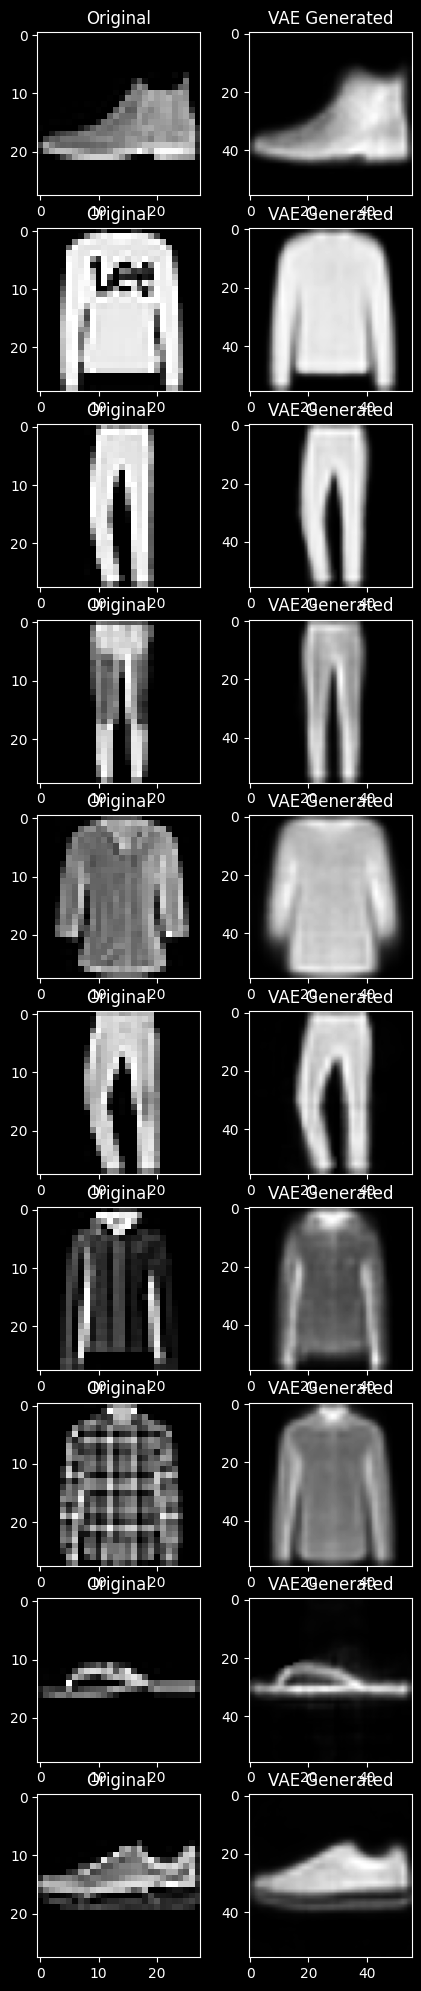

In [ ]:
f, ax = plt.subplots(10, 2);

f.set_figheight(25);
f.set_figwidth(5);

model.to(device)

for i in range(10):


  test_image1 = torch.from_numpy(x_test[i]).reshape(-1, 784);
  test_image1 = test_image1.to(device);

  decoded_image = model.test_image(test_image1);
  # print(decoded_image)

  ax[i][0].imshow(x_test[i], cmap="gray")
  ax[i][0].set_title("Original");

  ax[i][1].imshow(decoded_image.cpu().detach().numpy(), cmap="gray")
  ax[i][1].set_title("VAE Generated");


## Denoising

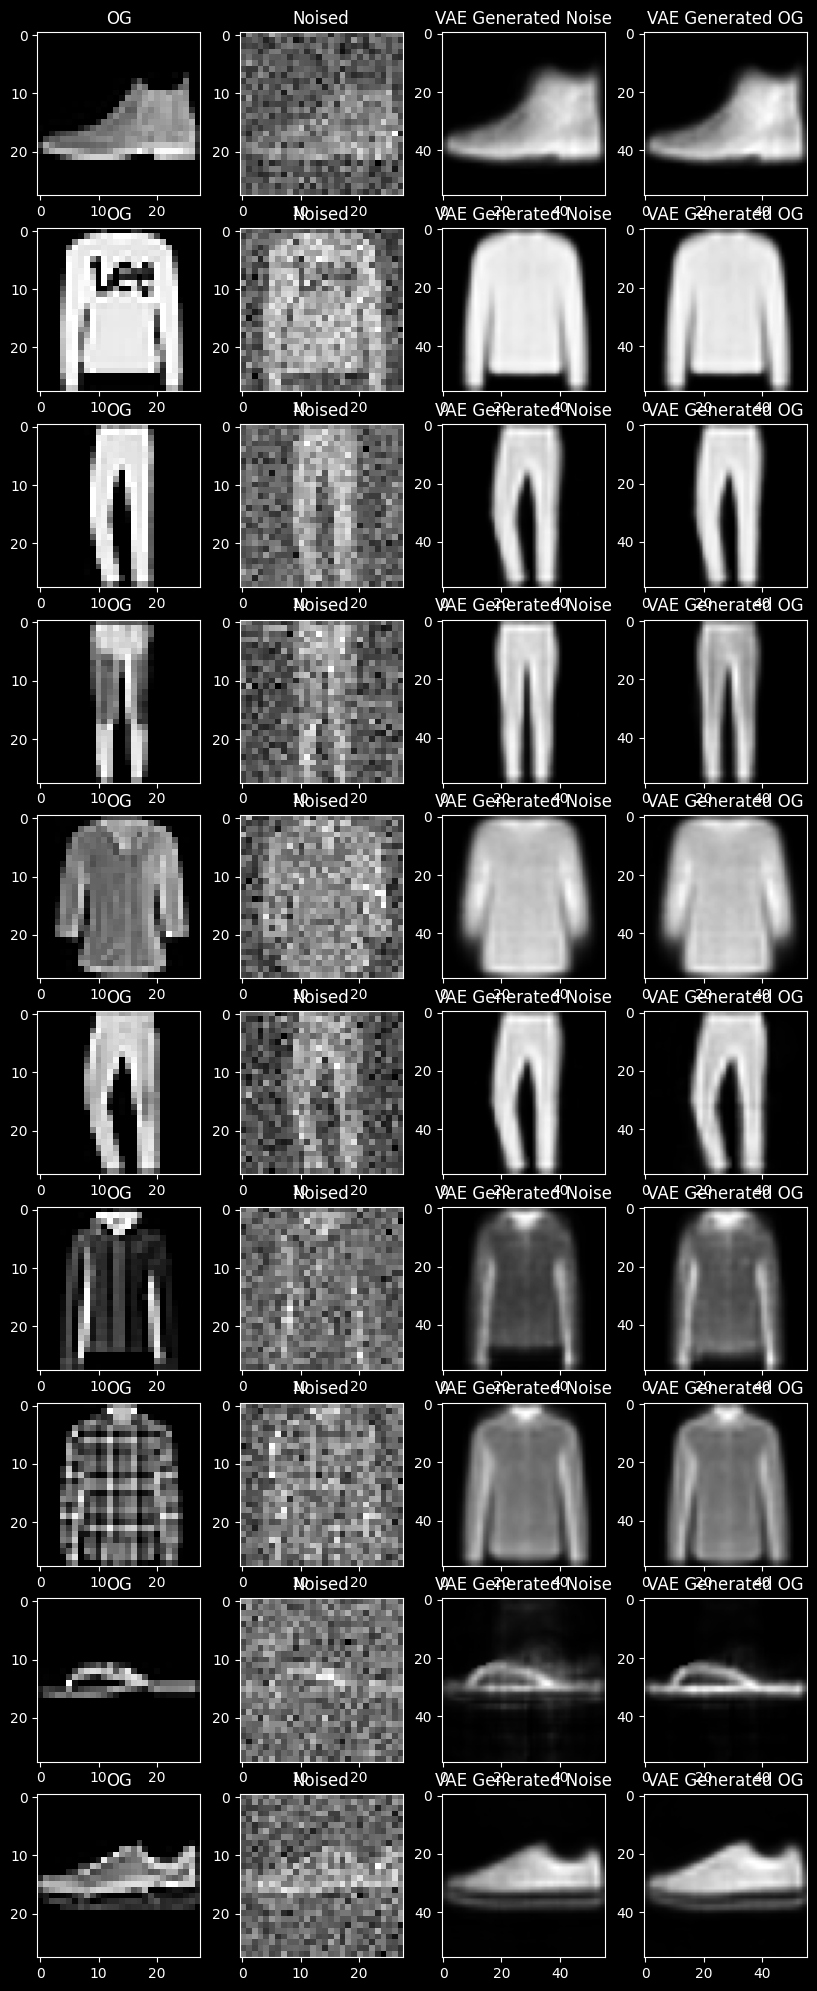

In [ ]:
f, ax = plt.subplots(10, 4);

f.set_figheight(25);
f.set_figwidth(10);

model.to(device)

for i in range(10):

  noise = np.random.normal(0, 0.3, x_test[i].shape)

  img_noised = x_test[i] + noise

  img_noised = img_noised.astype(np.float32)


  test_image1 = torch.from_numpy(img_noised).reshape(-1, 784);
  test_image1 = test_image1.to(device);

  test_image2 = torch.from_numpy(x_test[i]).reshape(-1, 784);
  test_image2 = test_image2.to(device);

  decoded_image1 = model.test_image(test_image2);
  decoded_image = model.test_image(test_image1);
  ax[i][0].imshow(x_test[i], cmap="gray")
  ax[i][0].set_title("OG");

  ax[i][1].imshow(test_image1.cpu().detach().numpy().reshape(28, 28), cmap="gray")
  ax[i][1].set_title("Noised");

  ax[i][2].imshow(decoded_image.cpu().detach().numpy(), cmap="gray")
  ax[i][2].set_title("VAE Generated Noise");

  ax[i][3].imshow(decoded_image1.cpu().detach().numpy(), cmap="gray")
  ax[i][3].set_title("VAE Generated OG");


